In [1]:
import os
from pprint import pprint as pp
import pandas as pd
import json
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import matplotlib
import itertools
import copy
import seaborn as sns

%matplotlib inline
os.getcwd()

'/home/ryan/Documents/insight_projects/steam_prices/data_analysis'

In [2]:
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier as RF
from sklearn.ensemble import ExtraTreesClassifier as ETC
from sklearn.neighbors import KNeighborsClassifier as KNN
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import roc_curve, auc
from sklearn.cross_validation import KFold
from sklearn.metrics import confusion_matrix

<H3>IMPORT STEAMDB FEATURES AND CLEAN MORE

In [3]:
df = pd.read_pickle('df_steamdb_timeseries.pkl')
since_sale_len = len(df.since_sale_lists[1])
print since_sale_len


21


<h4>data set choice parameters

In [4]:
current_epoch =  20 #the epoch in the bool list to predict
validation_set_prop = 0.20 #proportion of the entire data set to hold out for validation

In [5]:
#df.head()

drop_columns = ['fprice','iprice','price_date','sale_bool',
                'formatted_no_holiday','saledates_no_holiday',
               'sale_bool_all','min_iprice','mip_slopes','dirty_isi']
df_feat_space = df.drop(drop_columns,axis=1)
df_feat_space = df_feat_space[df_feat_space.formatted.map(type) != type([])]
#df_feat_space = df_feat_space.drop(['formatted'])
#df_feat_space['specific_epoch_time_since'] = df_feat_space.since_sale_lists[3]
#df.head()

In [6]:
'''empty list replace'''
replacement_empty_list = list(df.iloc[1].sale_bool_no_holiday[0] - df.iloc[1].sale_bool_no_holiday[0][0] + (60*60*24*100.0))
#if there are no values, for now just use this empty list that assumes the last sale was more than one hundred days ago
#however, this may be problematic if there's a negative correlation for games with sales and the time since the last game
#to_series = df_feat_space.since_sale_lists

to_series = df_feat_space.since_sale_lists
check = [x for x in to_series]
check_copy = copy.deepcopy(check)

just_one_epoch = list()
for i,v in enumerate(check):
    if v == []:
        check_copy[i] = replacement_empty_list
    cur_epoch_time_since = check_copy[i][current_epoch]
    just_one_epoch.append(cur_epoch_time_since)

df_feat_space['specific_epoch_time_since'] = just_one_epoch
#rint(check)
#[df_feat_space.head().iloc['since_sale_lists']

In [7]:
'''change boolean into 1 or 0'''
df_feat_space.has_price_slope = df_feat_space.has_price_slope.apply(lambda x:x*1)

In [8]:
'''make exponential cdf probability'''
day_sec = 60 * 60 * 24
twoweek_days = 14
time_since_ds = (df_feat_space.specific_epoch_time_since / day_sec) + 14
exp_lambda =  1/df_feat_space.dirty_isi_mean
df_feat_space['exp_cdf_time_since_prob'] =  1 - np.exp(-time_since_ds * exp_lambda)


<h3>STEAM SCRAPED FEATURES

In [9]:
df_steamscraped = pd.read_pickle('steam_features.pkl')

In [10]:
df_steamscraped.head()
drop_ss_cols = ['developer','game_name','meta_score','new_id','publisher','release_date','tag_data']
df_ss_features = df_steamscraped.drop(drop_ss_cols,axis =1)
df_ss_features.head()

,appid,time_stamp_rd,big_publisher,publisher_category,meta_score_mean_interpolate
0,317950,1416297600,False,small_publisher,72.40834
1,315940,1416297600,False,small_publisher,72.40834
2,363510,1416297600,False,small_publisher,72.40834
3,348870,1416297600,False,small_publisher,72.40834
4,348700,1416297600,False,small_publisher,72.40834


In [11]:
df_ss_features.big_publisher = df_ss_features.big_publisher.apply(lambda x:x*1) #turn into 1 or 0

In [12]:
unique_pubs = df_ss_features.publisher_category.unique()
le = LabelEncoder()
le.fit(df_ss_features.publisher_category)
df_ss_features['pub_cat_int'] = le.transform(df_ss_features.publisher_category)

In [13]:
df_merged_features = pd.merge(left=df_ss_features,right=df_feat_space, left_on='appid', right_on='appid')

In [14]:
df_merged_features['sale_count_x_dirty_isi_mean'] = df_merged_features.sale_count * df_merged_features.dirty_isi_mean
df_merged_features['exp_specific_epoch_time_since'] = np.exp(-df_merged_features.specific_epoch_time_since)
df_merged_features['sale_count_x_specific_epoch_time_since'] =df_merged_features.sale_count * df_merged_features.specific_epoch_time_since

<h4>make y values after tables are merged and everything else is calculated

In [15]:
'''make y values'''
yall = list()
for i,v in enumerate(df_merged_features.sale_bool_no_holiday):
    if v == []:
        y_in = 0
    else:
        y_in = v[1][current_epoch] #1 is the index of the boolean list
    yall.append(y_in)

yall = np.array(yall)

In [16]:

analyzed_appids = df_merged_features.appid
drop_more_columns = ['appid','formatted','since_sale_lists', 'sale_bool_no_holiday','publisher_category']
df_merged_features = df_merged_features.drop(drop_more_columns,axis=1)


In [17]:
feature_names = list(df_merged_features.columns.values)
print feature_names

['time_stamp_rd', 'big_publisher', 'meta_score_mean_interpolate', 'pub_cat_int', 'sale_count', 'has_price_slope', 'dirty_isi_mean', 'specific_epoch_time_since', 'exp_cdf_time_since_prob', 'sale_count_x_dirty_isi_mean', 'exp_specific_epoch_time_since', 'sale_count_x_specific_epoch_time_since']


In [18]:
Xall = df_merged_features.as_matrix().astype(np.float)

In [19]:
scaler = StandardScaler()
Xall = scaler.fit_transform(Xall)
#just learned that technically, this is incorrect, first you should do the split, then standardize the data

print "Feature space holds %d observations and %d features" % Xall.shape

Feature space holds 4163 observations and 12 features


<h4> split off a validation set

In [20]:
total_rows = yall.size
validation_size =  int(total_rows * 1.0 *  validation_set_prop)
validation_row_indices = np.sort(np.random.choice(range(total_rows),validation_size, replace = False))
traintest_row_indices =np.array(list(set(range(total_rows)) - set(list(validation_row_indices))))


In [21]:
Xv = Xall[validation_row_indices,:]
X = Xall[traintest_row_indices,:]

Yv = yall[validation_row_indices]
y = yall[traintest_row_indices]



<h4>run model

In [22]:

def run_cv(X,y,clf_class,**kwargs):
    # Construct a kfolds object
    kf = KFold(len(y),n_folds=5,shuffle=True)
    y_pred = y.copy()
    
    # Iterate through folds
    for train_index, test_index in kf:
        X_train, X_test = X[train_index], X[test_index]
        y_train = y[train_index]
        # Initialize a classifier with key word arguments
        clf = clf_class(**kwargs)
        clf.fit(X_train,y_train)
        y_pred[test_index] = clf.predict(X_test)
    return y_pred


In [23]:
def accuracy(y_true,y_pred):
    # NumPy interprets True and False as 1. and 0.
    return np.mean(y_true == y_pred)

print "Support vector machines:"
print "%.3f" % accuracy(y, run_cv(X,y,SVC))
print "Random forest:"
print "%.3f" % accuracy(y, run_cv(X,y,RF))
print "K-nearest-neighbors:"
print "%.3f" % accuracy(y, run_cv(X,y,KNN))

Support vector machines:
0.938
Random forest:
0.962
K-nearest-neighbors:
0.946


In [24]:
chance_accuracy = (1 - sum(y)*1.0 / y.size)

In [25]:

y = np.array(y)
class_names = np.unique(y)

confusion_matrices = [
    ( "Support Vector Machines", confusion_matrix(y,run_cv(X,y,SVC)) ),
    ( "Random Forest", confusion_matrix(y,run_cv(X,y,RF)) ),
    ( "K-Nearest-Neighbors", confusion_matrix(y,run_cv(X,y,KNN)) ),
]


In [26]:
confusion_matrices[0]

('Support Vector Machines', array([[2977,   19],
        [ 180,  155]]))

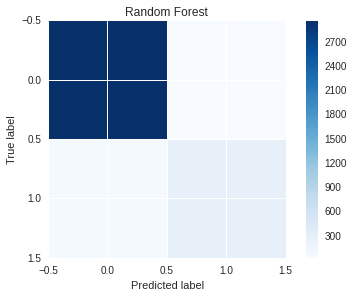

In [27]:
def plot_confusion_matrix(cm, title='Confusion matrix', cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    #tick_marks = np.arange(len(iris.target_names))
    #plt.xticks(tick_marks, iris.target_names, rotation=45)
    #plt.yticks(tick_marks, iris.target_names)
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')


look_at_model = 1
plot_confusion_matrix(confusion_matrices[look_at_model][1],confusion_matrices[look_at_model][0])


In [28]:
def run_prob_cv(X, y, clf_class, **kwargs):
    kf = KFold(len(y), n_folds=5, shuffle=True)
    y_prob = np.zeros((len(y),2)) #2 is the number of classes
    for train_index, test_index in kf:
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
        #y_train = y[train_index]
        clf = clf_class(**kwargs)
        clf.fit(X_train,y_train)
        # Predict probabilities, not classes
        y_prob[test_index] = clf.predict_proba(X_test)
        y_prob_all = clf.predict_proba(X_test)
    return y_prob, y_test, y_prob_all, clf

# def run_prob_cv(X, y, clf_class, **kwargs):
#     """TESTING"""
#     kf = KFold(len(y), n_folds=5, shuffle=True)
# #     y_prob = np.zeros((len(y),2))
#     for train_index, test_index in kf:
#         X_train, X_test = X[train_index], X[test_index]
#         y_train, y_test = y[train_index], y[test_index]
#         clf = clf_class(**kwargs)
#         clf.fit(X_train,y_train)
#         # Predict probabilities, not classes
#         y_prob = clf.predict_proba(X_test)
#     return y_test, y_prob

In [29]:
import warnings
warnings.filterwarnings('ignore')

# Use 10 estimators so predictions are all multiples of 0.1
pred_prob,y_test,y_prob_all,clf = run_prob_cv(X, y, RF, n_estimators=10)
pred_sale = pred_prob[:,1]
is_sale = y == 1

# Number of times a predicted probability is assigned to an observation
counts = pd.value_counts(pred_sale)

# calculate true probabilities
true_prob = {}
for prob in counts.index:
    true_prob[prob] = np.mean(is_sale[pred_sale == prob])
    true_prob = pd.Series(true_prob)

# pandas-fu
counts = pd.concat([counts,true_prob], axis=1).reset_index()
counts.columns = ['pred_prob', 'count', 'true_prob']
counts

,pred_prob,count,true_prob
0,0.000000,2761,0.008330
1,1.000000,199,0.989950
2,0.100000,127,0.118110
3,0.200000,56,0.196429
4,0.300000,40,0.225000
5,0.700000,30,0.666667
6,0.400000,29,0.241379
7,0.600000,22,0.454545
8,0.500000,21,0.571429
9,0.900000,20,0.800000


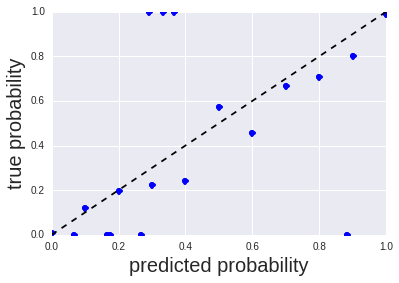

In [30]:
'''plot predicted probability by true probability'''
counts = counts.sort('pred_prob')
plt.plot(counts.pred_prob,counts.true_prob, 'bo')
plt.plot([0, 1], [0, 1], 'k--') 
plt.xlabel('predicted probability', fontsize = 20)
plt.ylabel('true probability',fontsize = 20)

In [31]:
Yv_predict = clf.predict(Xv)
accuracy(Yv,Yv_predict)

0.96875

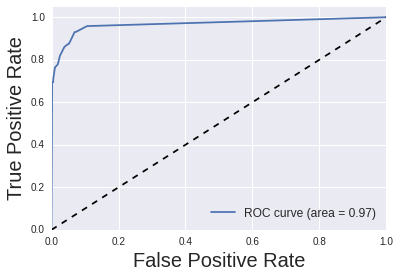

In [32]:
#y_score = classifier.fit(X_train, y_train).decision_function(X_test)
y_prob_all[:,1] # 1 is the 'positive' class
fpr, tpr,_ =roc_curve(y_test,y_prob_all[:,1])
roc_auc= auc(fpr, tpr)

plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')    
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize = 20)
plt.ylabel('True Positive Rate',fontsize = 20)
#plt.title('RF Receiver Operating Characteristic', fontsize = 20)
plt.legend(loc="lower right", fontsize = 12)
#rf_fpr, rf_tpr, thresholds = roc_curve(y_test, pred_prob[:, 1])`

<h4> Determine most important features

In [33]:

pred_prob,y_test,y_prob_all,clf_ETC = run_prob_cv(X, y, ETC, n_estimators=10)
importances = clf_ETC.feature_importances_
std = np.std([tree.feature_importances_ for tree in clf.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

Feature ranking:
1. feature 7 specific_epoch_time_since (0.277775)
2. feature 8 exp_cdf_time_since_prob (0.251503)
3. feature 11 sale_count_x_specific_epoch_time_since (0.227045)
4. feature 6 dirty_isi_mean (0.067062)
5. feature 9 sale_count_x_dirty_isi_mean (0.066517)
6. feature 4 sale_count (0.045655)
7. feature 2 meta_score_mean_interpolate (0.030242)
8. feature 5 has_price_slope (0.014700)
9. feature 3 pub_cat_int (0.012370)
10. feature 1 big_publisher (0.007132)
11. feature 10 exp_specific_epoch_time_since (0.000000)
12. feature 0 time_stamp_rd (0.000000)


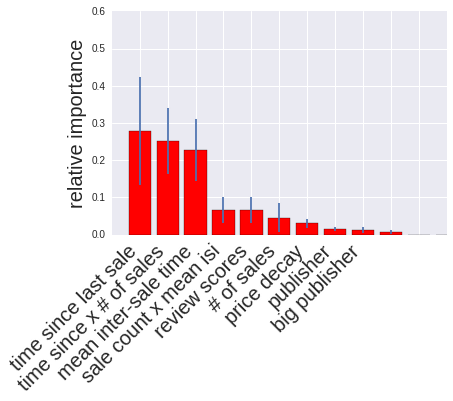

In [34]:
print("Feature ranking:")

for f in range(len(feature_names)):
    print("%d. feature %d %s (%f)" % (f + 1, indices[f], feature_names[indices[f]], importances[indices[f]]))

fig, ax = plt.subplots(1)
#ax.set_title("Feature importances")
ax.bar(range(len(feature_names)), importances[indices], color="r", yerr=std[indices], align="center")

ax.set_xlim([-1, 10])
ax.set_ylim([0,0.6])
#x.set_xlabel('feature')
ax.set_ylabel('relative importance', fontsize = 20)
ax.set_xticks(range(len(feature_names)))

feature_names_sorted = [feature_names[i] for i in indices] 
#
feature_names_sorted = ['time since last sale', 
                        'time since x # of sales', 
                        'mean inter-sale time',
                       'sale count x mean isi',
                        'review scores',
                        '# of sales',
                        'price decay',
                        'publisher',
                        'big publisher',
                        '',
                        '',]
                        
ax.set_xticklabels(feature_names_sorted, rotation='45', fontsize = 20, ha='right')

<h4>make probability data_frame

In [35]:
Yall_sale_prop = clf.predict_proba(Xall)[:,1] #1 is the probability of a sale

In [36]:
df_app_sale_prob = pd.DataFrame({'appid':analyzed_appids,'sale_prob': Yall_sale_prop}) 
#turn this into a moving window for later

In [37]:
#df_app_sale_prob.to_pickle('df_sale_prob.pkl')

In [38]:
pd.value_counts(pd.Series(clf.predict_proba(Xall)[:,1]))

0.000000    3517
1.000000     278
0.100000     112
0.200000      48
0.700000      33
0.300000      33
0.900000      31
0.400000      31
0.500000      25
0.600000      23
0.800000      22
0.881667       4
0.175000       3
0.366667       1
0.415000       1
0.266667       1
dtype: int64